In [1]:
!pip install turicreate==5.4
# The wrong version of MXNET will be installed
!pip uninstall -y mxnet
# Install CUDA10-compatible version of mxnet 
!pip install mxnet-cu100==1.4.0.post0

     |████████████████████████████████| 87.4MB 116kB/s 
     |████████████████████████████████| 327kB 49.2MB/s 
     |████████████████████████████████| 23.8MB 59.5MB/s 
     |████████████████████████████████| 2.7MB 29.8MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320847 sha256=2899fb3bfccf6fcf1f74aa1813333c62bb9de2701bcef8dd833fd429caa22e4b
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built resampy
ERROR: mxnet 1.1.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.17.4 which is incompatible.
ERROR: mxnet 1.1.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.21.0 which is incompatible.
  Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [1]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Google Drive already mounted


In [2]:
import mxnet as mx
import turicreate as tc

         To fix this, please install the currently recommended version:

             pip uninstall -y mxnet && pip install mxnet==1.1.0

         If you want to use a CUDA GPU, then change 'mxnet' to 'mxnet-cu90' (adjust 'cu90' depending on your CUDA version):



In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox

# Data loading

In [6]:
base_db = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/ML_Project/base_db.csv").drop(columns="Unnamed: 0")
base_db.head()

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
0,10108642,S,48.0,T,46.900000,Actinopterygii,Cypriniformes,Cyprinidae,Carassius,auratus,NR,1.93 (0.82-4.15) G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
1,88302,S,6.0,A,2.920000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,FI,NR,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
2,1397940,S,96.0,A,0.000063,Actinopterygii,Perciformes,Centrarchidae,Micropterus,salmoides,NR,20.5G,Fish
3,25474413,S,96.0,A,0.012000,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NR,1G,"Fish,Standard Test Species"
4,540727,F,36.0,T,144.000000,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,JV,0.62 G,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."


In [7]:
X_original = base_db.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]
X_original.head()

,test_cas,species,conc1_mean,obs_duration_mean
0,10108642,auratus,46.900000,48.0
1,88302,mykiss,2.920000,6.0
2,1397940,salmoides,0.000063,96.0
3,25474413,macrochirus,0.012000,96.0
4,540727,mykiss,144.000000,36.0


In [0]:
X_original = X_original[X_original.obs_duration_mean==96]

Number of positive sample 5694
Number of negative sample 3106


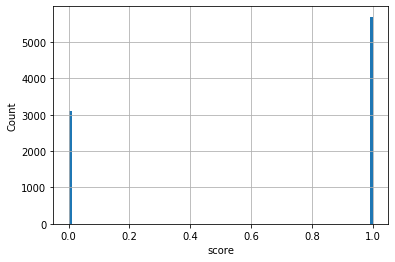

In [9]:
X_original = X_original.groupby(by=["test_cas", "species"]).agg("median").reset_index()
X_original["score"] = np.where(X_original.conc1_mean.values>1, 1, 0)

print("Number of positive sample", X_original[X_original.score==1].index.size)
print("Number of negative sample", X_original[X_original.score==0].index.size)

enc = OrdinalEncoder(dtype=int)
enc.fit(X_original[["test_cas", "species"]])
X_original[["test_cas", "species"]] = enc.transform(X_original[["test_cas", "species"]])
X_fact_scored = X_original.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index(drop=True)

# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

# Basic tests

In [0]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

In [48]:
X_train = tc.SFrame(X_train_scored)
X_train

test_cas,species,score
1256,404,1
271,336,1
1497,246,1
378,220,1
1587,220,1
70,159,1
1605,342,0
532,79,0
267,220,0
70,241,1


In [49]:
model = tc.recommender.factorization_recommender.create(X_train, 'test_cas', 'species', target='score', max_iterations=1000, binary_target=True)

Preparing data set.

Data has 5896 observations with 2089 users and 364 items.

Data prepared in: 0.01687s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| binary_target                  | Assume Binary Targets                            | True     |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 5896 / 5896 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | 0.115701                                 |

| 1       | 12.5              | 0.114682                                 |

| 2       | 6.25              | 0.104112                                 |

| 3       | 3.125             | 0.0525819                                |

| 4       | 1.5625            | 0.0271737                                |

| 5       | 0.78125           | 0.132446                                 |

+---------+-------------------+------------------------------------------+

| Final   | 1.5625            | 0.0271737                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 159us        | 0.650742          | 0.650742                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 12.388ms     | 0.65449           | 0.654395                          | 1.5625      |

| 2       | 23.029ms     | 0.386606          | 0.386503                          | 0.929068    |

| 3       | 32.142ms     | 0.233789          | 0.233683                          | 0.685455    |

| 4       | 38.076ms     | 0.104245          | 0.104138                          | 0.464534    |

| 5       | 47.731ms     | 0.0347043         | 0.0345952                         | 0.392948    |

| 10      | 85.644ms     | 0.00234145        | 0.00222937                        | 0.233648    |

| 50      | 302.621ms    | 0.00106752        | 0.000951056                       | 0.0698771   |

| 88      | 519.64ms     | 0.000880532       | 0.000762701                       | 0.0457299   |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training Predictive Error.

Final objective value: 0.000877426

Final training Predictive Error: 0.000759594

In [56]:
X_train_predict = model.predict(X_train)
X_train_predict

dtype: float
Rows: 5896
[0.9999984126552312, 0.9999789826460919, 0.9969061672832231, 0.9997247368879468, 0.999975619914374, 0.9978793734886815, 8.506380389437176e-06, 0.0016180968269965577, 2.0441611456648644e-07, 0.9999848372356851, 1.4017912209353535e-05, 0.9999701122221086, 1.5261653232543323e-07, 0.9999818606881923, 0.999999994525709, 0.0003835835620671909, 3.7222398343410044e-06, 1.2049594703834485e-10, 0.9999997901272751, 0.9999925319629698, 0.9999999999921116, 6.109333143746655e-05, 4.944493586621488e-06, 0.999999837055403, 0.9999075584957737, 0.9999999984036225, 0.0006700942477686773, 0.9999145914849801, 0.9999805889031722, 0.9999999057791313, 0.9999966379667607, 5.3679089413306734e-05, 5.2281770188357e-05, 0.999999985764743, 0.9999223542098216, 1.0725751326343845e-05, 0.999274833152013, 0.9999999895913873, 0.9998597985399177, 1.1243280368729675e-07, 0.0036580846703071134, 0.012627223479188864, 0.00013907638689236875, 9.396097651428513e-06, 0.00036340147300515085, 0.99999150614

In [57]:
X_train_predict = np.where(X_train_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_train_scored.score.values, X_train_predict)

1.0

In [0]:
X_test = tc.SFrame(X_test_scored)

In [59]:
model.evaluate_rmse(X_test, 'score')['rmse_overall']

0.39236052237200386

In [60]:
X_test_predict = model.predict(X_test)
X_test_predict

dtype: float
Rows: 2904
[0.9937866361728117, 0.004664203096121119, 0.9960662015632133, 0.005885022357057466, 0.9999811274147828, 0.9939591085121265, 0.9997929566303857, 0.9939591085121265, 0.45440201078683273, 0.94700522567786, 0.9939591085121265, 0.9967022471333606, 0.0010974881257031382, 0.9997763095417705, 0.7546904645690662, 0.9517863924703769, 0.7546904645690662, 0.9995733628616169, 0.9905058541372859, 0.9771592880175752, 0.9999999999998703, 0.999650923786387, 0.9999962415792727, 0.1707380059638726, 0.9939591085121265, 0.994393698791615, 0.0003131510230881829, 0.9999977003068025, 0.14022696330634787, 0.9436851526349281, 0.9939591085121265, 0.0027556556154589356, 0.9939591085121265, 0.7546904645690662, 0.9940877336378149, 0.0003087118320619597, 0.9939591085121265, 0.988791726616002, 0.9939591085121265, 0.8784446584401034, 4.284133437589903e-05, 0.9999807920377275, 0.9986023095440083, 0.9236807571839873, 0.012306634090526434, 0.32469305146477595, 0.9998889956466726, 0.00140111418337

In [61]:
X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_test_scored.score.values, X_test_predict)

0.8285123966942148

# Implementing CV

In [0]:
def cv_fact_class(X_scored, factors, regularizs, lin_regulars,  cv = 3, verbose=True, params_samples = True, num_samples = 5):
  best_factor = 0
  best_regulariz = 0
  best_lin_regulariz = 0
  best_acc = 0

  if params_samples:
    factors = np.random.choice(factors, num_samples)
    regularizs = np.random.choice(regularizs, num_samples)
    lin_regulars = np.random.choice(lin_regulars, num_samples)
    
  for factor in factors:
    for regulariz in regularizs:
      for lin_regular in lin_regulars:
        accs = []
        kf2 = KFold(n_splits=cv, shuffle=True)

        for train_ind, test_ind in kf2.split(X_scored):
          train = tc.SFrame(X_scored.loc[train_ind])
          test = tc.SFrame(X_scored.loc[test_ind])

          model = tc.recommender.factorization_recommender.create(train, 'test_cas', 'species', target='score', max_iterations=100, \
                                                                  num_factors = factor, regularization=regulariz, linear_regularization=lin_regular, solver="sgd", verbose=False, binary_target=True)
          
          X_test_predict = model.predict(test)
          X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
          acc = accuracy_score(X_scored.loc[test_ind].score.values, X_test_predict)
          accs.append(acc)
        
        acc_avg = np.mean(accs)
        if (acc_avg > best_acc):
          if verbose:
            print("New best param combination found! Acc:{}, num_factors:{}, regularizer:{}, lin_reg:{}".format(acc_avg, factor, regulariz, lin_regular))     
          best_acc = acc_avg
          best_lin_regulariz = lin_regular
          best_regulariz = regulariz
          best_factor = factor
    
  return best_acc, best_lin_regulariz, best_regulariz, best_factor


In [66]:
factors = list(range(5, 51, 5))
regularizs = np.logspace(-12, 0, 20)
lin_regularizs = np.logspace(-12, 0, 20)
best_acc, best_lin_regulariz, best_regulariz, best_factor = cv_fact_class(X_train_scored, factors, regularizs, lin_regularizs, cv = 3, verbose=True, params_samples = False)
pickle.dump(best_acc, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_acc_class.pkl", "wb" ) )
pickle.dump(best_lin_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_lin_reg_class.pkl", "wb" ) )
pickle.dump(best_regulariz, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_regulariz_class.pkl", "wb" ) )
pickle.dump(best_factor, open("/content/drive/My Drive/Colab Notebooks/data/ML_Project/best_factor_class.pkl", "wb" ) )

New best param combination found! Acc:0.799015839241663, num_factors:5, regularizer:1e-12, lin_reg:1e-12
New best param combination found! Acc:0.8013901292282629, num_factors:5, regularizer:1e-12, lin_reg:3.3598182862837877e-10
New best param combination found! Acc:0.8052935527375045, num_factors:5, regularizer:1e-12, lin_reg:6.158482110660254e-09
New best param combination found! Acc:0.8069884387427662, num_factors:5, regularizer:1e-12, lin_reg:4.832930238571752e-07
New best param combination found! Acc:0.8073263287593931, num_factors:5, regularizer:3.3598182862837877e-10, lin_reg:4.281332398719396e-12
New best param combination found! Acc:0.8085123951967157, num_factors:5, regularizer:3.3598182862837877e-10, lin_reg:2.6366508987303555e-08
New best param combination found! Acc:0.8085156740068872, num_factors:5, regularizer:2.6366508987303555e-08, lin_reg:7.847599703514623e-11
New best param combination found! Acc:0.809872669995522, num_factors:5, regularizer:2.06913808111479e-06, lin_

## Best params

In [0]:
# best_factor = 20
# best_regulariz = 0.0006951927961775591
# best_lin_regulariz = 1e-12

In [67]:
X_train = tc.SFrame(X_train_scored)
model = tc.recommender.factorization_recommender.create(X_train, 'test_cas', 'species', target='score', max_iterations=1000, \
                                                                  num_factors = best_factor, regularization=best_regulariz, linear_regularization=best_lin_regulariz, solver="sgd", verbose=True, binary_target=True)

Preparing data set.

Data has 5896 observations with 2089 users and 364 items.

Data prepared in: 0.014222s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 20       |

| regularization                 | L2 Regularization on Factors                     | 0.000695 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| binary_target                  | Assume Binary Targets                            | True     |

| max_iterations                 | Maximum Number of Iterations                     | 1000     |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 5896 / 5896 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 17.8645           | Not Viable                               |

| 1       | 4.46614           | 0.501824                                 |

| 2       | 2.23307           | 0.534785                                 |

| 3       | 1.11653           | Not Viable                               |

| 4       | 0.279134          | 0.391267                                 |

| 5       | 0.139567          | 0.414094                                 |

| 6       | 0.0697834         | 0.478875                                 |

| 7       | 0.0348917         | 0.528089                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.279134          | 0.391267                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 157us        | 0.650742          | 0.650742                          |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 13.024ms     | 0.549576          | 0.547223                          | 0.279134    |

| 2       | 20.033ms     | 0.44182           | 0.434223                          | 0.130185    |

| 3       | 28.225ms     | 0.413307          | 0.392711                          | 0.084888    |

| 4       | 53.148ms     | 0.397768          | 0.359283                          | 0.0629759   |

| 5       | 67.228ms     | 0.387921          | 0.332713                          | 0.0500552   |

| 10      | 98.598ms     | 0.369043          | 0.275913                          | 0.0247083   |

| 50      | 325.744ms    | 0.342577          | 0.240256                          | 0.00489173  |

| 100     | 597.667ms    | 0.332251          | 0.23362                           | 0.00242829  |

| 250     | 1.41s        | 0.320251          | 0.226707                          | 0.000974051 |

| 500     | 2.79s        | 0.312113          | 0.222243                          | 0.000487483 |

| 750     | 4.13s        | 0.307681          | 0.21987                           | 0.00032509  |

| 1000    | 5.56s        | 0.304662          | 0.218273                          | 0.000243856 |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 0.304694

Final training Predictive Error: 0.218306

In [68]:
X_test = tc.SFrame(X_test_scored)
model.evaluate_rmse(X_test, 'score')['rmse_overall']

0.3396389303055233

In [69]:
X_test_predict = model.predict(X_test)
X_test_predict = np.where(X_test_predict.to_numpy()>=0.5, 1, 0)
accuracy_score(X_test_scored.score.values, X_test_predict)

0.8495179063360881